# Text Classification - Sentiment Analysis - NLP

Buatlah model Sentiment Analysis menggunakan traditional Machine Learning algorithm dengan feature berupa bag of words. Gunakan data pada repository: https://github.com/IndoNLP/indonlu/tree/master/dataset/smsa_doc-sentiment-prosa 

Lakukan eksperimen untuk variasi feature extraction yang telah diajarkan di kelas yaitu bag of words dengan traditional ML algorithm (minimal 3 algoritme). Tetapkan preprocessing apa yang digunakan.

## Library Used

In [283]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import re
import string

In [284]:
data_train_preprocess =  pd.read_csv('data/train_preprocess.tsv', sep='\t', header=None, names=['text', 'label'])
data_test_preprocess = pd.read_csv('data/test_preprocess.tsv', sep='\t', header=None, names=['text', 'label'])
data_test_preprocess_masked_label = pd.read_csv('data/test_preprocess_masked_label.tsv', sep='\t', header=None, names=['text', 'label'])
data_valid_preprocess = pd.read_csv('data/valid_preprocess.tsv', sep='\t', header=None, names=['text', 'label'])

X_train = data_train_preprocess['text']
y_train = data_train_preprocess['label']

X_test = data_test_preprocess['text']
y_test = data_test_preprocess['label']

X_test_masked_label = data_test_preprocess_masked_label['text']
y_test_masked_label = data_test_preprocess_masked_label['label']

X_valid = data_valid_preprocess['text']
y_valid = data_valid_preprocess['label']

## Data Analysis

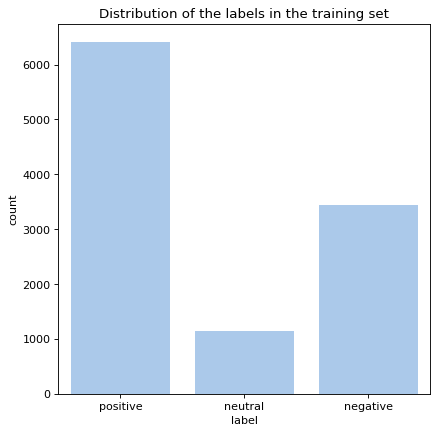

In [285]:
# data analysis

# Graph of the distribution of the labels
def plot_distribution(y, title):
    sns.set_palette('pastel')
    plt.figure(figsize=(6, 6), dpi=80)
    sns.countplot(x=y)
    plt.title(title)
    plt.show()
    
plot_distribution(y_train, 'Distribution of the labels in the training set')

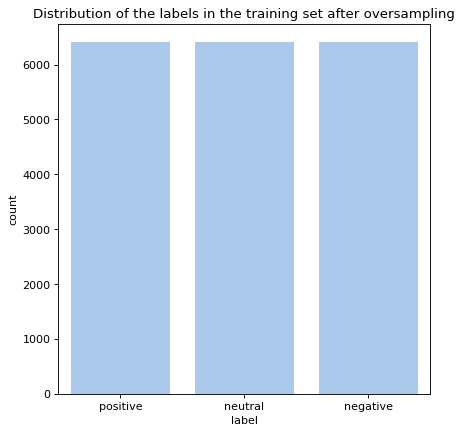

In [286]:
# solve the problem of class imbalance with RandomOverSampler

ros = RandomOverSampler(random_state=0)
X_train_oversample, y_train_oversample = ros.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train))

# Graph of the distribution of the labels after solving the problem of class imbalance
y_train_oversample = y_train_oversample["label"]
X_train_oversample = X_train_oversample["text"]

plot_distribution(y_train_oversample, 'Distribution of the labels in the training set after oversampling')

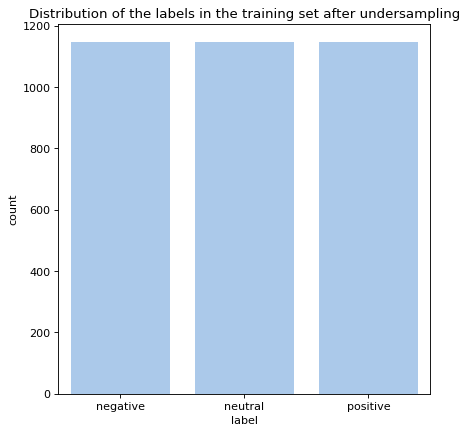

In [287]:
# solve the problem of class imbalance with undersampling

rus = RandomUnderSampler(random_state=0)
X_train_undersample, y_train_undersample = rus.fit_resample(pd.DataFrame(X_train), pd.DataFrame(y_train))

# Graph of the distribution of the labels after solving the problem of class imbalance
y_train_undersample = y_train_undersample["label"]
X_train_undersample = X_train_undersample["text"]

plot_distribution(y_train_undersample, 'Distribution of the labels in the training set after undersampling')

## Preprocessing

In [288]:
def preprocess_text(text: str) -> str:
    # lower case
    text = text.lower()
    
    # remove special characters
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # entity masking
    # url masking
    text = re.sub(r'http\S+', 'url', text)
    # email masking
    text = re.sub(r'\S+@\S+', 'email', text)
    # phone number masking 9 digits or more, with or without space, with - or without
    text = re.sub(r'(\d{9,}|\d{3,}[-\s]\d{3,}[-\s]\d{3,})', 'phone_number', text)
    # number masking
    text = re.sub(r'\d+', 'number', text)
    
    return text

X_train_oversample = X_train_oversample.apply(lambda x: preprocess_text(x))
X_train_undersample = X_train_undersample.apply(lambda x: preprocess_text(x))
X_train_normal = X_train.apply(lambda x: preprocess_text(x))

X_test = X_test.apply(lambda x: preprocess_text(x))
X_test_masked_label = X_test_masked_label.apply(lambda x: preprocess_text(x))
X_valid = X_valid.apply(lambda x: preprocess_text(x))

## Feature Extraction (Bag of Words)

In [289]:
# Initialize vectorizer globally so the same one can be used for both train and test

# Function to fit on training data and transform to bag of words
def bag_of_words(texts_train: pd.Series, texts_test: pd.Series) -> np.ndarray:
    vectorizer = CountVectorizer(max_features=1000)
    X_train = vectorizer.fit_transform(texts_train).toarray()
    X_test = vectorizer.transform(texts_test).toarray()
    return X_train, X_test

## Labels Encoding

In [290]:
# Encoding the labels
y_train_oversample = LabelEncoder().fit_transform(y_train_oversample)
y_train_undersample = LabelEncoder().fit_transform(y_train_undersample)
y_train_normal = LabelEncoder().fit_transform(y_train)

y_test = LabelEncoder().fit_transform(y_test)
y_test_masked_label = LabelEncoder().fit_transform(y_test_masked_label)
y_valid = LabelEncoder().fit_transform(y_valid)

# display the label encoding and its corresponding class
label_mapping = dict(zip(LabelEncoder().fit(y_train).transform(LabelEncoder().fit(y_train).classes_), LabelEncoder().fit(y_train).classes_))
print(label_mapping)

{0: 'negative', 1: 'neutral', 2: 'positive'}


## Model

### Logistic Regression 

In [291]:
# Model training
# Logistic Regression
def logistic_regression(X_train, y_train, X_test, y_test):
    if type(X_train) == pd.Series:
        X_train, X_test = bag_of_words(X_train, X_test)
    # Model training
    logistic_regression = LogisticRegression(max_iter=1000)
    logistic_regression.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = logistic_regression.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return logistic_regression

In [292]:
# Logistic Regression
print('Logistic Regression')
print('normal')
logistic_regression(X_train_normal, y_train_normal, X_test, y_test)
print('undersample')
logistic_regression(X_train_undersample, y_train_undersample, X_test, y_test)
print('oversample')
logrec = logistic_regression(X_train_oversample, y_train_oversample, X_test, y_test)

Logistic Regression
normal
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       204
           1       0.80      0.44      0.57        88
           2       0.82      0.79      0.80       208

    accuracy                           0.77       500
   macro avg       0.78      0.71      0.73       500
weighted avg       0.78      0.77      0.76       500

undersample
              precision    recall  f1-score   support

           0       0.65      0.92      0.76       204
           1       0.54      0.70      0.61        88
           2       0.88      0.42      0.57       208

    accuracy                           0.67       500
   macro avg       0.69      0.68      0.65       500
weighted avg       0.73      0.67      0.65       500

oversample
              precision    recall  f1-score   support

           0       0.72      0.91      0.80       204
           1       0.71      0.61      0.66        88
           2       0.87  

In [226]:
text = ['aku buruk sekali', 'saya sangat senang', 'sekolah adalah tempat belajar']
text = [preprocess_text(x) for x in text]
text = pd.Series(text)
vectorizer = CountVectorizer(max_features=1000)
y_predict = np.array([0, 2, 1])

In [227]:
logistic_regression(X_train_oversample, y_train_oversample, text, y_predict)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



LogisticRegression(max_iter=1000)

In [296]:
print('normal')
logistic_regression(X_train_normal, y_train_normal, X_valid, y_valid)
print('oversample')
logistic_regression(X_train_oversample, y_train_oversample, X_valid, y_valid)

normal
              precision    recall  f1-score   support

           0       0.78      0.84      0.81       394
           1       0.71      0.69      0.70       131
           2       0.92      0.89      0.90       735

    accuracy                           0.85      1260
   macro avg       0.80      0.81      0.81      1260
weighted avg       0.86      0.85      0.85      1260

oversample
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       394
           1       0.61      0.80      0.69       131
           2       0.95      0.84      0.89       735

    accuracy                           0.84      1260
   macro avg       0.78      0.83      0.80      1260
weighted avg       0.86      0.84      0.85      1260



LogisticRegression(max_iter=1000)

In [294]:
# X train oversample after bag of words
X_train_normal_bow, X_test_bow = bag_of_words(X_train_normal, X_test)
ros = RandomOverSampler(random_state=0)
X_train_oversample_new, y_train_oversample_new = ros.fit_resample(X_train_normal_bow, y_train_normal)

Hasil dari logistic regression dengan data oversampling setelah dilakukan feature extraction dengan bag of words adalah sebagai berikut:

In [295]:
logistic_regression(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_test)

              precision    recall  f1-score   support

           0       0.71      0.92      0.80       204
           1       0.67      0.66      0.67        88
           2       0.90      0.65      0.75       208

    accuracy                           0.76       500
   macro avg       0.76      0.74      0.74       500
weighted avg       0.78      0.76      0.76       500



LogisticRegression(max_iter=1000)

In [264]:
_, X_test_bow = bag_of_words(X_train_normal, X_valid)
logistic_regression(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_valid)

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       394
           1       0.57      0.79      0.66       131
           2       0.95      0.83      0.89       735

    accuracy                           0.83      1260
   macro avg       0.76      0.82      0.78      1260
weighted avg       0.85      0.83      0.84      1260



LogisticRegression(max_iter=1000)

### Naive Bayes

In [299]:
# Naive Bayes
def naive_bayes(X_train, y_train, X_test, y_test):
    if type(X_train) == pd.Series:
        X_train, X_test = bag_of_words(X_train, X_test)
        
    # Model training
    naive_bayes = MultinomialNB(alpha=0.8)
    naive_bayes.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = naive_bayes.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return naive_bayes

In [303]:
_, X_test_bow = bag_of_words(X_train_normal, X_test)

print('oversample new')
naive_bayes(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_test)

print('normal')
naive_bayes(X_train_normal, y_train_normal, X_test, y_test)

print('undersample')
naive_bayes(X_train_undersample, y_train_undersample, X_test, y_test)

print('oversample')
naive_bayes(X_train_oversample, y_train_oversample, X_test, y_test)


oversample new
              precision    recall  f1-score   support

           0       0.58      0.98      0.73       204
           1       0.54      0.51      0.53        88
           2       0.83      0.30      0.44       208

    accuracy                           0.61       500
   macro avg       0.65      0.60      0.57       500
weighted avg       0.68      0.61      0.58       500

normal
              precision    recall  f1-score   support

           0       0.58      0.97      0.73       204
           1       0.48      0.35      0.41        88
           2       0.75      0.35      0.47       208

    accuracy                           0.60       500
   macro avg       0.61      0.56      0.54       500
weighted avg       0.63      0.60      0.57       500

undersample
              precision    recall  f1-score   support

           0       0.57      0.97      0.72       204
           1       0.52      0.53      0.53        88
           2       0.90      0.26      0.

MultinomialNB(alpha=0.8)

In [274]:
naive_bayes(X_train_oversample, y_train_oversample, X_valid, y_valid)

bag of words
              precision    recall  f1-score   support

           0       0.76      0.84      0.80       394
           1       0.70      0.76      0.73       131
           2       0.92      0.86      0.89       735

    accuracy                           0.84      1260
   macro avg       0.80      0.82      0.81      1260
weighted avg       0.85      0.84      0.84      1260



MultinomialNB(alpha=0.8)

### k-Nearst Neighbors

In [234]:
#  k-Nearest Neighbors
def knn(X_train, y_train, X_test, y_test):
    if type(X_train) == pd.Series:
        X_train, X_test = bag_of_words(X_train, X_test)
        
    # Model training
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = knn.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return knn

In [305]:
knn(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_test)

print ('normal')
knn(X_train_normal, y_train_normal, X_test, y_test)

print ('undersample')
knn(X_train_undersample, y_train_undersample, X_test, y_test)

print ('oversample')
knn(X_train_oversample, y_train_oversample, X_test, y_test)

              precision    recall  f1-score   support

           0       0.59      0.57      0.58       204
           1       0.38      0.72      0.50        88
           2       0.55      0.36      0.43       208

    accuracy                           0.51       500
   macro avg       0.51      0.55      0.51       500
weighted avg       0.54      0.51      0.51       500

normal
              precision    recall  f1-score   support

           0       0.59      0.57      0.58       204
           1       0.38      0.72      0.50        88
           2       0.55      0.36      0.43       208

    accuracy                           0.51       500
   macro avg       0.51      0.55      0.51       500
weighted avg       0.54      0.51      0.51       500

undersample
              precision    recall  f1-score   support

           0       0.54      0.70      0.61       204
           1       0.31      0.76      0.45        88
           2       0.68      0.07      0.13       208

 

KNeighborsClassifier(n_neighbors=1)

### CatBoost

In [307]:
# catboost
def catboost(X_train, y_train, X_test, y_test):
    if type(X_train) == pd.Series:
        X_train, X_test = bag_of_words(X_train, X_test)
        
    # Model training
    catboost = CatBoostClassifier(iterations=3000, learning_rate=0.1, depth=6, loss_function='MultiClass', verbose=False)
    catboost.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = catboost.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return catboost

In [308]:
catboost(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_test)

print ('normal')
catboost(X_train_normal, y_train_normal, X_test, y_test)

print ('undersample')
catboost(X_train_undersample, y_train_undersample, X_test, y_test)

print ('oversample')
catboost(X_train_oversample, y_train_oversample, X_test, y_test)

              precision    recall  f1-score   support

           0       0.68      0.95      0.79       204
           1       0.67      0.60      0.63        88
           2       0.91      0.61      0.73       208

    accuracy                           0.75       500
   macro avg       0.76      0.72      0.72       500
weighted avg       0.78      0.75      0.74       500

normal
              precision    recall  f1-score   support

           0       0.68      0.94      0.79       204
           1       0.80      0.49      0.61        88
           2       0.86      0.69      0.76       208

    accuracy                           0.75       500
   macro avg       0.78      0.70      0.72       500
weighted avg       0.78      0.75      0.75       500

undersample
              precision    recall  f1-score   support

           0       0.64      0.93      0.76       204
           1       0.51      0.73      0.60        88
           2       0.92      0.35      0.50       208

 

In [309]:
print ('normal')
catboost(X_train_normal, y_train_normal, X_valid, y_valid)

print ('oversample')
catboost(X_train_oversample, y_train_oversample, X_valid, y_valid)

normal
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       394
           1       0.71      0.70      0.70       131
           2       0.92      0.91      0.91       735

    accuracy                           0.86      1260
   macro avg       0.81      0.82      0.81      1260
weighted avg       0.87      0.86      0.86      1260

oversample
              precision    recall  f1-score   support

           0       0.82      0.85      0.84       394
           1       0.67      0.79      0.72       131
           2       0.94      0.89      0.91       735

    accuracy                           0.87      1260
   macro avg       0.81      0.84      0.82      1260
weighted avg       0.87      0.87      0.87      1260



### Support Vector Machine (SVM)

In [238]:

# Model training
# Support Vector Machine
def support_vector_machine(X_train, y_train, X_test, y_test):
    if type(X_train) == pd.Series:
        X_train, X_test = bag_of_words(X_train, X_test)
    # Model training
    svm = SVC(kernel='linear')
    svm.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = svm.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return svm

In [239]:
# Support Vector Machine
print('Support Vector Machine')
print('normal')
support_vector_machine(X_train_normal, y_train_normal, X_test, y_test)
print('undersample')
support_vector_machine(X_train_undersample, y_train_undersample, X_test, y_test)
print('oversample')
svm = support_vector_machine(X_train_oversample, y_train_oversample, X_test, y_test)

Support Vector Machine
normal
              precision    recall  f1-score   support

           0       0.70      0.94      0.80       204
           1       0.73      0.49      0.59        88
           2       0.88      0.72      0.79       208

    accuracy                           0.77       500
   macro avg       0.77      0.71      0.73       500
weighted avg       0.78      0.77      0.76       500

undersample
              precision    recall  f1-score   support

           0       0.63      0.87      0.73       204
           1       0.51      0.66      0.57        88
           2       0.85      0.42      0.56       208

    accuracy                           0.65       500
   macro avg       0.66      0.65      0.62       500
weighted avg       0.70      0.65      0.63       500

oversample
              precision    recall  f1-score   support

           0       0.66      0.92      0.77       204
           1       0.72      0.55      0.62        88
           2       0.8

In [240]:
print('oversample after bag of words')
support_vector_machine(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_test)

oversample after bag of words
              precision    recall  f1-score   support

           0       0.66      0.94      0.78       204
           1       0.68      0.55      0.60        88
           2       0.92      0.62      0.74       208

    accuracy                           0.74       500
   macro avg       0.75      0.70      0.71       500
weighted avg       0.77      0.74      0.73       500



SVC(kernel='linear')

### Random Forest

In [241]:
# Model training
# Random Forest
def random_forest(X_train, y_train, X_test, y_test):
    if type(X_train) == pd.Series:
        X_train, X_test = bag_of_words(X_train, X_test)
    # Model training
    random_forest = RandomForestClassifier(n_estimators=100)
    random_forest.fit(X_train, y_train)
    
    # Model evaluation
    y_pred = random_forest.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    return random_forest

In [242]:
# Random Forest
print('Random Forest')
print('normal')
random_forest(X_train_normal, y_train_normal, X_test, y_test)
print('undersample')
random_forest(X_train_undersample, y_train_undersample, X_test, y_test)
print('oversample')
rf = random_forest(X_train_oversample, y_train_oversample, X_test, y_test)

Random Forest
normal
              precision    recall  f1-score   support

           0       0.62      0.90      0.73       204
           1       0.68      0.34      0.45        88
           2       0.80      0.60      0.68       208

    accuracy                           0.68       500
   macro avg       0.70      0.61      0.62       500
weighted avg       0.70      0.68      0.66       500

undersample
              precision    recall  f1-score   support

           0       0.57      0.93      0.71       204
           1       0.51      0.62      0.56        88
           2       0.83      0.24      0.37       208

    accuracy                           0.59       500
   macro avg       0.64      0.60      0.55       500
weighted avg       0.67      0.59      0.54       500

oversample
              precision    recall  f1-score   support

           0       0.58      0.93      0.71       204
           1       0.60      0.33      0.43        88
           2       0.84      0.

In [243]:
print('oversample after bag of words')
random_forest(X_train_oversample_new, y_train_oversample_new, X_test_bow, y_test)

oversample after bag of words
              precision    recall  f1-score   support

           0       0.57      0.93      0.71       204
           1       0.60      0.36      0.45        88
           2       0.83      0.47      0.60       208

    accuracy                           0.64       500
   macro avg       0.67      0.59      0.59       500
weighted avg       0.69      0.64      0.62       500



RandomForestClassifier()

### other algorithm

In [244]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

# Grid search to find the best parameters
text_clf = Pipeline([
    ('vect', CountVectorizer()), # Bag of words
    ('tfidf', TfidfTransformer()), # TF-IDF
    ('clf', SGDClassifier()), # Stochastic Gradient Descent
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (2, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-2, 1e-3),
    'clf__penalty': ('l2', 'elasticnet'),
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1)

In [245]:
gs_clf = gs_clf.fit(X_train_normal, y_train_normal)
print(gs_clf.best_score_)

0.8326363636363638


In [246]:
gs_clf_under = gs_clf.fit(X_train_undersample, y_train_undersample)
print(gs_clf_under.best_score_)

0.8411697944442569


In [247]:
gs_clf_over = gs_clf.fit(X_train_oversample, y_train_oversample)
print(gs_clf_over.best_score_)

0.9105378290195126


In [248]:
# result model
# print the best parameters
print(gs_clf_over.best_params_)

y_pred = gs_clf_over.predict(X_valid)
print(classification_report(y_valid, y_pred))

{'clf__alpha': 0.001, 'clf__penalty': 'l2', 'tfidf__use_idf': True, 'vect__ngram_range': (2, 2)}
              precision    recall  f1-score   support

           0       0.76      0.75      0.76       394
           1       0.76      0.62      0.68       131
           2       0.87      0.91      0.89       735

    accuracy                           0.83      1260
   macro avg       0.80      0.76      0.77      1260
weighted avg       0.83      0.83      0.83      1260



In [249]:
y_pred = gs_clf_over.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.86      0.73       204
           1       0.51      0.40      0.45        88
           2       0.74      0.57      0.64       208

    accuracy                           0.66       500
   macro avg       0.63      0.61      0.61       500
weighted avg       0.66      0.66      0.65       500

